# Analysis of scCNR reconstruction

In this notebook we analyze and interpret the CNR results obtained in the notebook 06-scmra-full-model.ipynb

For now, we focus on the CNR analysis where we compared all cell states with each other. Later, we might also focus on Cluster 5 vs all other clusters.

We have obtained:

  * A scan over different values of $\theta$, from which we concluded that $\theta=0.2$ gives a good model complexity.
  * Sample permutation which can be used to obtain the distribution of edge strengths (and their difference from the population mean). 
  These permutations were constructed such that the number of cells, and the distribution of treatments, remained intact and only the cell-state cluster assignment for each cell was randomized.

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches as mpatches
import scmra
import networkx as nx
import random
import itertools
import pickle
import cplex
import statsmodels.stats.multitest

# Temporary for autocompletion. See this issue 
# https://github.com/conda-forge/conda-forge-repodata-patches-feedstock/issues/81#event-3664361521
%config Completer.use_jedi = False

# Fix some font issues
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams.update({'figure.autolayout': True})
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
# plt.rcParams['font.family'] = 'Helvetica'
sns.set_context("notebook")

matplotlib.rc('xtick', labelsize=6) 
matplotlib.rc('ytick', labelsize=6) 
matplotlib.rc('axes', labelsize=8) 
matplotlib.rc('legend',**{'fontsize':6})

## MRA

In [2]:
with open('../results/full-network-mra-eta-scan.pickle', 'rb') as f:
    sol_mra_eta = pickle.load(f)
    
with open('../results/mra_random_network_mssr.txt', 'r') as f:
    random_mssr = [float(x) for x in f.read().splitlines()]

with open('../results/mra_random_network_mssr-batch2.txt', 'r') as f:
    tmp = [float(x) for x in f.read().splitlines()]
    random_mssr += tmp

sol_mra = sol_mra_eta[0.6]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


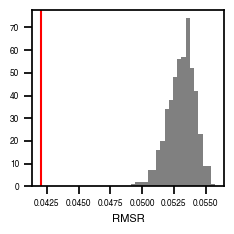

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(2.5, 2.5);
plt.hist(random_mssr, bins=20, color="gray");
plt.axvline(sol_mra.mssr, color="red");
plt.xlabel("RMSR");
plt.tight_layout();
plt.savefig("../figures/scIDseq/CNR/mra-rmse-random-network.pdf")

## CNR

In [4]:
with open('../results/theta-scan.pickle', 'rb') as f:
    sols_theta = pickle.load(f)
    
# Data frame with all nodes that have a significant interaction term
df_ia = pd.read_csv("../results/treatment_cellstate_interactions_anova.tsv", sep="\t")

sol_ref = sols_theta[0.2]

sol_ref.deviations_overview.to_csv("../results/CNR-solution-deviation-overview.tsv", sep="\t")

In [5]:
# verview of deviations from mean of the solution in long/tidy form
sol_dev_tidy = sol_ref.deviations_overview.sub(sol_ref.deviations_overview["mean"], axis=0)
sol_dev_tidy = sol_dev_tidy.drop('mean', axis=1)
sol_dev_tidy = sol_dev_tidy.melt(var_name = "Cluster", value_name = "Deviation", ignore_index=False)
sol_dev_tidy['Edge'] = sol_dev_tidy.index
sol_dev_tidy = sol_dev_tidy[['Edge', "Cluster", "Deviation"]]

In [6]:
ab_mapping_phospho = {
    # Phospho-antibodies
    # MAPK
    "EGFR_P_Y1045": "EGFRY1045", "EGFR_P_Y1173": "EGFRY1173",
    "ERK1_2_P": "ERK12",
    "RSK1_P_T359": "RSK1T359", # "RSK1_P_S380": "RSK1S380", 
    #AKT
    "AKT1_P": "AKT1", "AKT123_P": "AKT123",
    "MTOR_P": "MTOR",
    "GSK3B_P": "GSK3B",
    "RIBOSOMAL_S6_P": "RPS6", "RB_P": "RB",
     # Other
    "JNK_P": "JNK", "CJUN_P": "CJUN",
    # FAK (ITGB1 is not a phospho, but treated as input node (all incoming edges = 0))
    "ITGB1": "ITGB1", 'SRC_P': "SRC", 'FAK_P': "FAK",
    # JAK-STAT  
    "JAK1_P": "JAK1", "STAT1_P": "STAT1", "STAT3_P": "STAT3", "STAT5_P": "STAT5",
    # WNT
    "LRP6_P": "LRP6", "FRIZZLED_3": "FZD",
     # SMAD
    "BMP2_4": "BMP", "BMPRII": "BMPR", "SMAD1_5_9_P": "SMAD159", 
    "SMAD1_5_P": "SMAD15", "SMAD2_3_P": "SMAD23",
    # MKK3
    "MKK3_6_P": "MKK36", "MAPK_P38_P": "P38", "MAPK_P38_P2": "P38D",
    "MAPK_APK2_P": "MAPKAP2",  "CREB_P": "CREB",
    # TNFalpa
    'IKBA_P': "IKBA", 'NFKB_P65_P': "P65", "RELA_P": "RELA",
    # Output nodes
    "CMYC": "CMYC", "CFOS_P": "CFOS", # Not a phospho-p, but "activated" by pRSK
    "CDC2": "CDC2", "CDK4": "CDK4", "CYCLIN_E": "CYCLINE", "CYCLIN_B1": "CYCLINB1", 
    "H2A_P": "H2A", "H3_P": "H3",  "RB_P": "RB",
}


# Map to nodes.
ab_mapping_tot = {    
    # Total protein antibodies 
    "ERK1_2": "ERK12",
    "AKT2": ["AKT1", "AKT123"], 
    "JNK": "JNK", 
    "SRC": "SRC", "FAK": "FAK",
    "JAK1": "JAK1", "STAT1": "STAT1",
    "SMAD1": ["SMAD159", "SMAD15"], "SMAD3": "SMAD23",
    "IKBA": "IKBA",
    "RELA": "RELA"
}

In [7]:
dev_edges = set([tuple(i.split("_")[1:]) for i,j in sol_ref.allowed_deviations.items() \
                if (i.startswith("IDev") and j == 1)])
all_edges = set([tuple(key.split("_")[1:]) for key, val in sol_ref.vardict.items() \
                 if key.startswith("I_") and val == 1])
nondev_edges = set(all_edges) - set(dev_edges)
# nondev_edges = set([tuple(i.split("_")[1:]) for i,j in sol_ref.allowed_deviations.items() \
#                     if (i.startswith("IDev") and j == 0)])
# nondev_edges = nondev_edges.intersection(all_edges)
all_nodes = sol_ref.nodes
# Nodes with significant interaction term
ia_nodes = set([ab_mapping_phospho[i] for i in list(df_ia.ab_name) if i in ab_mapping_phospho.keys()])

### Network visualization

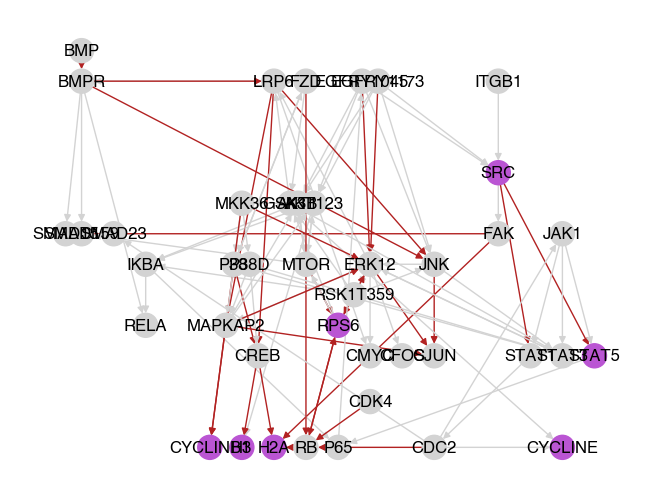

In [8]:
added_edges = [('EGFRY1045', 'P65'),
 ('SMAD159', 'MTOR'),
 ('LRP6', 'BMPR'),
 ('CDC2', 'STAT1'),
 ('P38', 'FZD'),
 ('H2A', 'CREB'),
 ('CMYC', 'LRP6'),
 ('CYCLINB1', 'MAPKAP2'),
 ('CYCLINB1', 'MKK36'),
 ('JNK', 'RSK1T359'),
 ('SMAD15', 'FAK'),
 ('RELA', 'BMPR'),
 ('JNK', 'LRP6'),
 ('H2A', 'RB'),
 ('ERK12', 'STAT3'),
 ('ERK12', 'MAPKAP2'),
 ('BMPR', 'LRP6'),
 ('JNK', 'BMPR'),
 ('MAPKAP2', 'LRP6'),
 ('RB', 'RPS6'),
 ('AKT1', 'GSK3B'),
 ('CREB', 'LRP6'),
 ('RB', 'FZD'),
 ('ERK12', 'RPS6'),
 ('P65', 'STAT5'),
 ('SMAD23', 'STAT1'),
 ('CJUN', 'MAPKAP2'),
 ('FZD', 'P38'),
 ('RPS6', 'RB'),
 ('H2A', 'FAK'),
 ('ERK12', 'JNK'),
 ('ERK12', 'MKK36'),
 ('JAK1', 'STAT5')]


node_positions = {
    "BMP": (-1, 1), "BMPR": (-1, 0), "SMAD15": (-1.5, -5), "SMAD159": (-1, -5),
                                    "SMAD23": (0, -5),
    "IKBA": (1, -6), "RELA": (1, -8),
    "MKK36": (4, -4), "P38": (3.75, -6), "P38D": (4.25, -6), "MAPKAP2": (3.5, -8), "CREB": (4.5, -9),
    "LRP6": (5, 0), "FZD": (6 , 0), "GSK3B": (5.5, -4), 
    "EGFRY1045": (7.75, 0), "EGFRY1173": (8.25, 0), 
    "AKT1": (5.75, -4), "AKT123": (6.25, -4), "MTOR": (6, -6), "RPS6": (7, -8),
                                            "ERK12": (8, -6), "RSK1T359": (7.5, -7), "CMYC": (8, -9), "CFOS": (9, -9), 
                                            "JNK": (10, -6), "CJUN": (10, -9),
    "ITGB1": (12, 0), "SRC": (12, -3),  "FAK": (12, -5),
    "JAK1": (14, -5), "STAT1": (13, -9), "STAT3": (14, -9), "STAT5": (15, -9),
    "CYCLINB1": (3, -12),  "H2A": (5, -12), "CDC2": (10, -12), "RB": (6, -12), "P65": (7, -12), 
    "CDK4": (8, -10.5), "CYCLINE": (14, -12), "H3": (4, -12)
    }


def get_graph(sol):
    """Generate graph from complete solution.

    This graph includes perturbations as nodes, and edges from
    perturbations to the affected nodes.

    input:
    * sol: A ScCnrResult object.

    output: An networkx DiGraph object
    """
    g = nx.DiGraph()
    
    for node in sol.nodes:
        g.add_node(node)
   
    # Go over all variables from the solution.
    for var, val in sol.vardict.items():
        # select the local response coefficients
        if var.startswith("I_") and val == 1:
            base, n1, n2 = var.split("_")
            from_n = n2
            to_n = n1
            # Check if edge deviates between cell state clusters
            if (to_n, from_n) in dev_edges:
                color = "firebrick"
            else:
                color = "lightgray"
            
            # Check is edge is added in the network reconstruction
            if (to_n, from_n) in added_edges:
                added = True
            else:
                added = False
                
            # Get type of edge
            rloc_vars = ["_".join(["r", group, n1, n2]) for group in sol.groups]
            rloc_vals = [sol.vardict[rvar] for rvar in rloc_vars]
            if sum(rloc_vals)/len(rloc_vals) > 0:
                interaction = "activates"
            else:
                interaction = "inhibits"

            g.add_edge(from_n, to_n, color = color, isadded=added, 
                       interaction=interaction)
    
    
    pos_x = dict()
    pos_y = dict()
    node_color = dict()
    for node, pos in node_positions.items():
        g.nodes[node]['pos'] = pos
        pos_x[node] = int(35*pos[0])
        pos_y[node] = int(-35*pos[1])
        if node in ia_nodes:
            node_color[node] = "mediumorchid"
        else:
            node_color[node] = "lightgray"
    nx.set_node_attributes(g, pos_x, name='x')
    nx.set_node_attributes(g, pos_y, name='y')
    nx.set_node_attributes(g, node_color, name='color')
    return g



g = get_graph(sol_ref)
edge_colors = nx.get_edge_attributes(g,'color').values()
node_colors = nx.get_node_attributes(g,'color').values()

nx.draw(g, edge_color=edge_colors, node_color=node_colors, 
        with_labels = True, pos=node_positions)
# plt.savefig("../../figures/scIDseq/CNR/Graph-differences-states.pdf")
# nx.write_gml(g, "../../results/scIDseq/graph_states.gml")

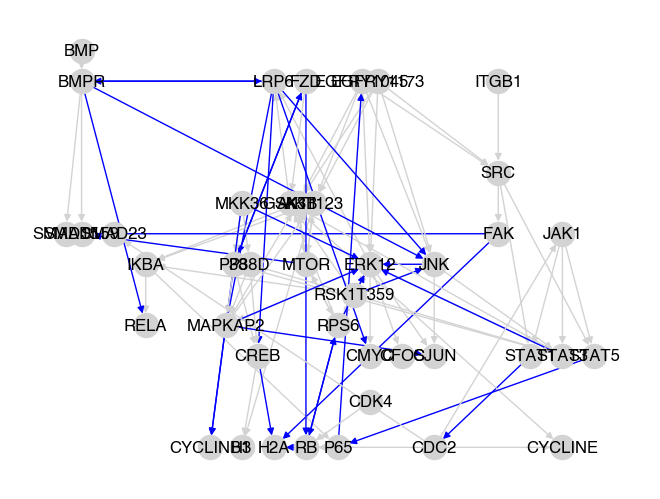

In [9]:
col_dict = {True: "blue", False: "lightgray"}
edge_colors = [col_dict[val] for val in nx.get_edge_attributes(g,'isadded').values()]

nx.draw(g, edge_color=edge_colors, node_color="lightgray", 
        with_labels = True, pos=node_positions)
#plt.savefig("../../figures/scIDseq/CNR/Graph-added-edges.pdf")
# nx.write_gml(g, "../../results/scIDseq/graph_added.gml")

### Enrichment analysis

To assess the relation between nodes that show a cell state specific response and edges that differ in strength between cell states, we look whether edges that differ between states are more likely to connect to nodes that show a cell state specific response. Conversely, we also look if nodes that show a cell state specific response are more likely to have incoming edges that differ between states.

#### Edge enrichment

|                     | connected to node with interaction term |not connected to node with interaction term  |
| -------------       |   ---                                   | ---                                             |
|edges deviating      | | |
| edges not deviating | | |


Is there an enrichment for connecting to a node with an interaction term among edges that are predicted to be deviating? Below we get the contingency table.

In [10]:
assert ia_nodes.issubset(sol_ref.nodes)

# Get dev_edges that link to node in ia_nodes
de_ia = []
de_nia = []
for edge in dev_edges:
    if bool(ia_nodes.intersection(edge)):
        de_ia.append(edge)
    else:
        de_nia.append(edge)

        
nde_ia = []
nde_nia = []
for edge in nondev_edges:
    if bool(ia_nodes.intersection(edge)):
        nde_ia.append(edge)
    else:
        nde_nia.append(edge)

# Some sanity checks
assert len(de_ia) + len(de_nia) == len(dev_edges)        
assert len(nde_ia) + len(nde_nia) == len(nondev_edges)        

cont_table_edges = [[len(de_ia), len(de_nia)], [len(nde_ia), len(nde_nia)]]

pd.DataFrame(
    cont_table_edges, 
    index = ["edges deviating", "edges nondeviating"],
    columns = ["connected to node with interaction", "not connected to node with interaction"]
)

,connected to node with interaction,not connected to node with interaction
edges deviating,13,18
edges nondeviating,11,57


The Fisher exact test below shows a clearly significant enrichment?

In [11]:
scipy.stats.fisher_exact(cont_table_edges, alternative = "greater")

(3.742424242424242, 0.00677247325113006)

We also visualize the contingency table

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


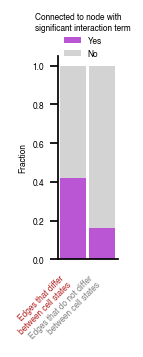

In [12]:
bars = ["Edges that differ\nbetween cell states", "Edges that do not differ\nbetween cell states"]
prop_table_edges = [
    [x/sum(cont_table_edges[0]) for x in cont_table_edges[0]],
    [x/sum(cont_table_edges[1]) for x in cont_table_edges[1]]
]
red_bars = [v[0] for v in prop_table_edges]
gray_bars = [v[1] for v in prop_table_edges]


barWidth = 0.9
fig, ax = plt.subplots()
fig.set_size_inches(1.5, 4);
plt.bar(bars, red_bars, color="mediumorchid", width=barWidth, label="Yes");
plt.bar(bars, gray_bars, bottom=red_bars, color="lightgray", width=barWidth, label="No");
plt.ylabel("Fraction", fontsize=6);
ax.get_xticklabels()[0].set_color("firebrick")
ax.get_xticklabels()[1].set_color("gray")
ax.spines['top'].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="x", bottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(-0.5,1.25), ncol=1, 
           frameon=False, prop={'size': 6}, 
           title = "Connected to node with\nsignificant interaction term",
          title_fontsize=6);
plt.tight_layout();
plt.savefig("../figures/scIDseq/CNR/enrichment-edges.pdf")

THis is based on the following fractions

In [13]:

pd.DataFrame(
    prop_table_edges, 
    index = ["fraction of deviating edges", "fraction of nondeviating edges"],
    columns = ["connected to node with interaction", "not connected to node with interaction"]
)

,connected to node with interaction,not connected to node with interaction
fraction of deviating edges,0.419355,0.580645
fraction of nondeviating edges,0.161765,0.838235


#### Node enrichment

Is there an enrichment for having an incoming edge deviating between cell states for nodes with an interaction term? 

In [14]:
# Nodes with imcoming edge deviating
nds_dev_ed = set([edge[0] for edge in dev_edges])

# Nodes without an incoming edge deviating
other_nodes = set(sol_ref.nodes) - ia_nodes
    
assert len(ia_nodes.intersection(nds_dev_ed)) + len(ia_nodes - nds_dev_ed) == len(ia_nodes)
assert len(other_nodes.intersection(nds_dev_ed)) + len(other_nodes - nds_dev_ed) == len(other_nodes)


cont_table_nodes = [
    [len(ia_nodes.intersection(nds_dev_ed)),    len(ia_nodes - nds_dev_ed)],
    [len(other_nodes.intersection(nds_dev_ed)), len(other_nodes - nds_dev_ed)]]

pd.DataFrame(cont_table_nodes, 
             index = ["Nodes with interaction", "Nodes without interaction"],
             columns = ["Incoming deviating edge", "No non-deviating edge"]
            )


,Incoming deviating edge,No non-deviating edge
Nodes with interaction,5,2
Nodes without interaction,10,25


There is an enrichment, but it is just barely significant. Possibly due to the lower numbers...

In [15]:
scipy.stats.fisher_exact(cont_table_nodes, alternative = "greater")

(6.25, 0.04431790583908683)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


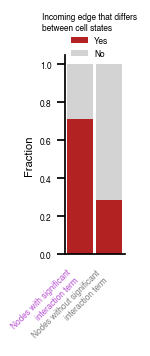

In [16]:
bars = ["Nodes with significant\ninteraction term", "Nodes without significant\ninteraction term"]
prop_table_nodes = [
    [x/sum(cont_table_nodes[0]) for x in cont_table_nodes[0]],
    [x/sum(cont_table_nodes[1]) for x in cont_table_nodes[1]]
]
red_bars = [v[0] for v in prop_table_nodes]
gray_bars = [v[1] for v in prop_table_nodes]

matplotlib.rc('xtick', labelsize=6) 
matplotlib.rc('ytick', labelsize=6) 
matplotlib.rc('legend',**{'fontsize':6})

barWidth = 0.9
fig, ax = plt.subplots()
fig.set_size_inches(1.5, 4);
plt.bar(bars, red_bars, color="firebrick", width=barWidth, label="Yes")
plt.bar(bars, gray_bars, bottom=red_bars, color="lightgray", width=barWidth, label="No")
plt.ylabel("Fraction", fontsize=8)
ax.get_xticklabels()[0].set_color("mediumorchid")
ax.get_xticklabels()[1].set_color("gray")
ax.spines['top'].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="x", bottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(-0.5,1.25), ncol=1, 
           frameon=False, prop={'size': 6}, 
           title = "Incoming edge that differs\nbetween cell states",
          title_fontsize=6);
plt.tight_layout();
plt.savefig("../figures/scIDseq/CNR/enrichment-nodes.pdf", pad_inches=10)

In [17]:
pd.DataFrame(prop_table_nodes, 
             index = ["Fraction of nodes with interaction", "Fractions of nodes without interaction"],
             columns = ["Incoming deviating edge", "No non-deviating edge"]
            )

,Incoming deviating edge,No non-deviating edge
Fraction of nodes with interaction,0.714286,0.285714
Fractions of nodes without interaction,0.285714,0.714286


### Sample permutation analysis

To obtain a null model for the distrubition differences between edge values, we randomly permuted the cell state labels 1000 times, and reoptimized the edge strenghts.

In [18]:
with open('../results/sample-permutation/cnr_full-restricteddevs_batch1.pickle', 'rb') as f:
    sol_permutations_cnr = pickle.load(f)

with open('../results/sample-permutation/cnr_full-restricteddevs_batch2.pickle', 'rb') as f:
    tmp = pickle.load(f)
sol_permutations_cnr += tmp

with open('../results/sample-permutation/cnr_full-restricteddevs_batch3.pickle', 'rb') as f:
    tmp = pickle.load(f)
sol_permutations_cnr += tmp    

with open('../results/sample-permutation/cnr_full-restricteddevs_batch4.pickle', 'rb') as f:
    tmp = pickle.load(f)
sol_permutations_cnr += tmp    
    
with open('../results/sample-permutation/cnr_full-restricteddevs_batch5.pickle', 'rb') as f:
    tmp = pickle.load(f)
sol_permutations_cnr += tmp



In [19]:
len(sol_permutations_cnr)

1000

In [20]:
df_permutations = pd.concat([s.deviations_overview for s in sol_permutations_cnr], sort=True)
recur_diffs_permutations = df_permutations.index.value_counts()/len(sol_permutations_cnr)
recur_diffs_permutations = pd.DataFrame({"fraction": recur_diffs_permutations[recur_diffs_permutations > 0.5]})

df_permutations = pd.concat(
    [s.deviations_overview for s in sol_permutations_cnr], 
    sort=True
)

df_permutations

,1,2,3,4,5,6,7,8,9,mean
p_ip70S6K.EGF_RPS6,-0.262488,-0.355883,-0.057133,-0.207475,-0.335731,-0.325024,-0.281245,-0.160224,-0.068279,-0.228165
r_BMPR_BMP,-0.337552,0.05188,-0.022461,0.111692,0.124778,-0.05384,-0.15265,-0.265016,0.130052,-0.045902
r_CJUN_ERK12,0.083138,-0.110877,0.108721,0.10562,0.211148,0.236195,0.185049,0.323387,0.208456,0.150093
r_CJUN_JNK,0.154442,0.294625,-0.291982,0.099413,-0.015838,0.335163,0.027985,-0.10677,0.165556,0.073621
r_CJUN_MAPKAP2,0.537628,1.163131,0.605975,0.54863,0.629686,0.761261,0.643158,0.431592,0.368356,0.632157
...,...,...,...,...,...,...,...,...,...,...
r_SMAD15_FAK,0.763292,0.473181,0.447023,0.415415,0.773552,0.503882,0.782264,0.554459,0.586134,0.5888
r_STAT1_SRC,0.092637,0.34031,0.319357,0.104998,0.361999,0.315995,0.354511,0.295292,0.248507,0.270401
r_STAT5_SRC,0.291877,0.452421,0.30914,0.148255,0.447118,0.358468,0.385359,0.139918,0.247851,0.308934
s_AKT1,0.410599,0.024161,0.403519,0.553191,0.267624,0.180483,0.538499,0.4258,0.366822,0.3523


In [21]:
# Get overview of deviations from mean of all permutations in long/tidy form
deviating_vars = list(sol_ref.deviations_overview.index)
#indicators = [key for key, val in sol_ref.vardict.items() if key.startswith("I_") and val == 1]

df_lst = []
for sol in sol_permutations_cnr:
    df = pd.DataFrame(columns=list(sol.groups) + ['mean'], index=deviating_vars)
    for i in deviating_vars:
        info = i.split("_")#
        vars_lst = ['_'.join(info[:1] + [group] + info[1:]) for group in sol.groups]
        vars_vals = [sol.vardict[v] for v in vars_lst]
        vars_vals.append(np.mean(vars_vals))
        df.loc[i] = vars_vals

    df_lst.append(df)

perm_dev_tidy = pd.concat(df_lst)
perm_dev_tidy = perm_dev_tidy.sub(perm_dev_tidy['mean'], axis=0)
perm_dev_tidy = perm_dev_tidy.drop("mean", axis=1)
perm_dev_tidy = perm_dev_tidy.melt(
    var_name = "Cluster", value_name = "Deviation", 
    ignore_index=False)
perm_dev_tidy['Edge'] = perm_dev_tidy.index
perm_dev_tidy = perm_dev_tidy[["Edge", "Cluster", "Deviation"]]

del sol_permutations_cnr, tmp


THis allows us to calculate a p-values for the difference in edge strenghts between cell states

In [22]:
def get_permutation_pvalue(df_sol, **kwargs):
    # Get deviation from mean of edge in solution
    var = df_sol.Edge
    group = df_sol.Cluster
    sol_val = df_sol.Deviation
    
    df_perm = kwargs['df_perm']
    # Get distribion of deviations from mean of edge from permutations
    perm_vals = abs(df_perm.loc[(df_perm.Edge == var) & (df_perm.Cluster == group), "Deviation"])
    
    n_larger = (abs(perm_vals) > abs(sol_val)).sum()
    n_permutations = len(perm_vals)
    pval = (n_larger + 1)/(n_permutations + 1)
    return pval

def get_permutation_zscore(df_sol, **kwargs):
    # Get deviation from mean of edge in solution
    var = df_sol.Edge
    group = df_sol.Cluster
    sol_val = df_sol.Deviation
    
    df_perm = kwargs['df_perm']
    # Get distribion of deviations from mean of edge from permutations
    perm_vals = df_perm.loc[(df_perm.Edge == var) & (df_perm.Cluster == group), "Deviation"]
    zscore = (sol_val - perm_vals.mean())/perm_vals.std()
    
    return zscore



sol_dev_tidy['pval'] = sol_dev_tidy.apply(
    get_permutation_pvalue,  
    df_perm = perm_dev_tidy, axis=1
)


sol_dev_tidy['zscore'] = sol_dev_tidy.apply(
    get_permutation_zscore,  
    df_perm = perm_dev_tidy, axis=1
)

sol_dev_tidy = sol_dev_tidy.sort_values(by=["pval", "Deviation"])
#sol_dev.Cluster = pd.Series(sol_dev.Cluster, dtype="ch")
sol_dev_tidy["fdr"] = statsmodels.stats.multitest.multipletests(
    sol_dev_tidy.pval, method="fdr_bh")[1]
sol_dev_tidy[sol_dev_tidy.fdr < 0.05]

,Edge,Cluster,Deviation,pval,zscore,fdr
r_RB_FZD,r_RB_FZD,4,-2.840289,0.000999,-5.005799,0.021835
r_RB_CDC2,r_RB_CDC2,4,-2.397692,0.000999,-4.801500,0.021835
r_CYCLINB1_MKK36,r_CYCLINB1_MKK36,5,-1.554104,0.000999,-6.112960,0.021835
r_LRP6_BMPR,r_LRP6_BMPR,1,-0.791361,0.000999,-4.619184,0.021835
r_BMPR_BMP,r_BMPR_BMP,1,-0.73622,0.000999,-3.376870,0.021835
r_H3_CREB,r_H3_CREB,5,-0.585225,0.000999,-5.054684,0.021835
r_CREB_LRP6,r_CREB_LRP6,3,-0.39632,0.000999,-3.346884,0.021835
r_H2A_RB,r_H2A_RB,7,-0.183501,0.000999,-3.121233,0.021835
r_CREB_P38,r_CREB_P38,1,0.58482,0.000999,3.151330,0.021835
r_H2A_RB,r_H2A_RB,5,0.848201,0.000999,12.157069,0.021835


In [23]:
sol_dev_tidy.to_csv("../results/cnr-sampleperm-pvals.tsv", sep="\t")

We can visualize this using a volcano plot (note that the lowest possible FDR is 0.0218)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


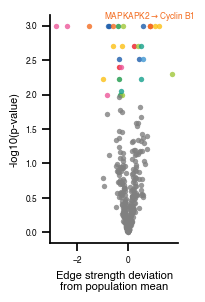

In [24]:
tmp = sol_dev_tidy.copy(deep=True)
tmp['logpval'] = -np.log10(tmp.pval)
tmp["Cell state"] = [str(c) for c in list(tmp.Cluster)]
tmp.loc[tmp['fdr'] > 0.1, 'Cell state'] = 'gray' 

x_annot = float(tmp.loc[(tmp.Edge == "r_CYCLINB1_MAPKAP2") & (tmp.Cluster == "5"), "Deviation"])
y_annot = float(tmp.loc[(tmp.Edge == "r_CYCLINB1_MAPKAP2") & (tmp.Cluster == "5"), "logpval"])

pltheight = 3
pltwidth = 2.

plt.rcParams.update({'font.size': 6})

colors = [
 "#1C5DAB", "#ED1C24", "#1B9948","#ED579A", "#F36D21", "#3E96D2", "#A0C73A", "#FCC014", "#14A08C", "gray"
]

customPalette = sns.set_palette(sns.color_palette(colors))

sns.lmplot(
    x = "Deviation",y = "logpval", data = tmp, 
    hue = "Cell state", fit_reg=False, legend=False,
    scatter_kws={"s": 15, "edgecolor": None, "linewidths": 0},
    hue_order = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "gray"],
    palette=customPalette,
    height=pltheight, aspect=pltwidth/pltheight
);
plt.text(x_annot, y_annot+0.1, r'MAPKAPK2$\rightarrow$Cyclin B1',
         horizontalalignment='center', color="#F36D21")
plt.xlabel("Edge strength deviation\nfrom population mean");
plt.ylabel("-log10(p-value)");
#ax.spines['top'].set_visible(False)
#ax.spines["right"].set_visible(False)
plt.tight_layout();
plt.savefig("../figures/scIDseq/CNR/volcano-plot-MAPKAPK2.pdf")


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


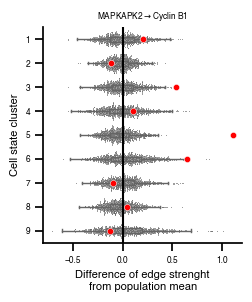

In [25]:
edge = "r_CYCLINB1_MAPKAP2"

def swamplot_permutations(sol, df_perm, var):

    # Prepare data from permutation 
    tmp = df_perm.loc[var].reset_index(drop=True)
    tmp = tmp.sub(tmp['mean'], axis=0) # Get differences from population mean
    tmp = tmp.drop("mean", axis=1).melt() # Remove mean
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(2.5, 3);
    plt.axvline(x=0, color="black")


    sns.swarmplot(
        y = "variable", x = "value", data=tmp, color = "gray", s=0.5, zorder=0,
    )
    sns.boxplot(
        y = "variable", x = "value", data=tmp, color = "darkgray",
        boxprops={'facecolor':'None'}, width=0.2, showfliers = False, linewidth=1, zorder=1,
    )
    
    sns.scatterplot(
        y = "variable", x = "value", markers = '.',
        data = sol.deviations_overview.drop('mean', axis=1).loc[[var]].melt(),
        color = "red", s = 20, zorder=2
    )


    plt.ylabel("Cell state cluster");
    plt.xlabel("Difference of edge strenght\nfrom population mean");
    plt.title(var);
    ax.spines['top'].set_visible(False)
    ax.spines["right"].set_visible(False)


    return plt


plt = swamplot_permutations(sol_ref, df_permutations, edge)
plt.title(r'MAPKAPK2$\rightarrow$Cyclin B1', fontsize=6);
plt.tight_layout();
plt.savefig("../figures/scIDseq/CNR/r_CYCLINB1_MAPKAP2.pdf")


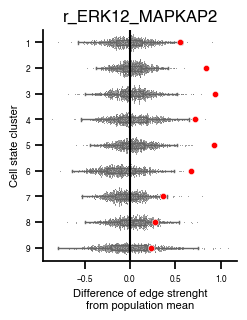

In [26]:
swamplot_permutations(sol_ref, df_permutations, "r_ERK12_MAPKAP2");

/Users/evertbosdriesz/opt/miniconda3/envs/scmra/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evertbosdriesz/opt/miniconda3/envs/scmra/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evertbosdriesz/opt/miniconda3/envs/scmra/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evertbosdriesz/opt/miniconda3/envs/scmra/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnin

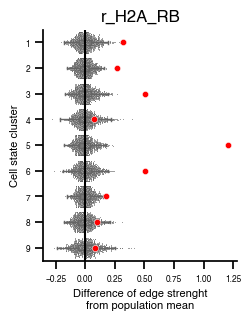

In [27]:
swamplot_permutations(sol_ref, df_permutations, "r_H2A_RB");

#### Cell state resolved enrichment analysis

We can also test for enrichment in a more fine-grained manner. 
To this end, we can test if nodes that show a significant interaction term in a specific cluster (i.e. not from the ANOVA but from the regression analysis).
The downside of this analysis is that the results depend on the reference cluster for the regression analysis.

Let's first use cluster 1 as reference cluster.

In [28]:
df_ia_c1 = pd.read_csv("../results/treatment_cellstate_interactions.tsv", sep="\t")

# Only keep ABs that map to a node
df_ia_c1 = df_ia_c1[[ab in list(ab_mapping_phospho.keys()) for ab in df_ia_c1.ab_name]]

# Make sure nodes are consistent between analyses
assert set(sol_ref.nodes) == set(ab_mapping_phospho.values())

# # Add column with node name 
df_ia_c1['node'] = [ab_mapping_phospho[ab] for ab in df_ia_c1.ab_name]
df_ia_c1.head()

,ab_name,term,cluster,treatment,estimate,std.error,statistic,p.value,fdr,term_type,node
0,H3_P,cluster5:treatmentiRSK_EGF,5,iRSK_EGF,-2.306481,0.366220,-6.298080,6.429544e-10,3.242994e-08,interaction,H3
1,CYCLIN_E,cluster9:treatmentip70S6K_EGF,9,ip70S6K_EGF,2.112157,0.390883,5.403559,9.971879e-08,3.096268e-06,interaction,CYCLINE
2,JAK1_P,cluster9:treatmentip70S6K_EGF,9,ip70S6K_EGF,1.654364,0.385520,4.291252,2.120030e-05,3.211069e-04,interaction,JAK1
3,NFKB_P65_P,cluster9:treatmentip70S6K_EGF,9,ip70S6K_EGF,1.392239,0.355285,3.918652,1.009683e-04,1.279618e-03,interaction,P65
5,STAT5_P,cluster9:treatmentip70S6K_EGF,9,ip70S6K_EGF,1.431129,0.375202,3.814291,1.530062e-04,1.850978e-03,interaction,STAT5


##### Per cluster edge enrichment

How many nodes show cell state dependent drug response?

Text(0, 0.5, 'Number of nodes with significant\ninteraction term')

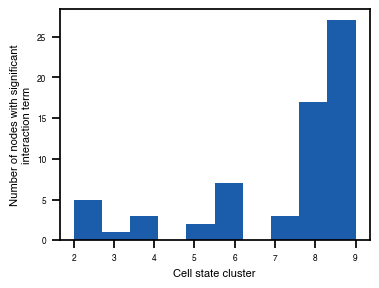

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(4, 3);
plt.hist(df_ia_c1.cluster);
plt.xlabel("Cell state cluster");
plt.ylabel("Number of nodes with significant\ninteraction term")

In [30]:
# For each cluster (except the reference cluster)
de_ia = [] # Deviating and interaction
de_nia = [] # Deviating, no interaction
nde_ia = [] # Not deviating, interaction
nde_nia = [] # Not deviating, no interaction

for cluster in set(df_ia_c1.cluster):
    # Get nodes with a significant interaction term in that cluster
    ia_nodes_cluster = set(df_ia_c1[df_ia_c1.cluster == cluster].node)

    # Get significant deviating edges in that cluster
    dev_pars = set(sol_dev_tidy[(sol_dev_tidy.pval < 0.05) & (sol_dev_tidy.Cluster == str(cluster))].Edge)
    dev_edges_cluster = set([tuple(par.split("_")[1:]) for par in dev_pars if par.startswith("r_")])
    nondev_edges_cluster = set(all_edges) - set(dev_edges_cluster)
    # Update contingency table entries.
    for edge in dev_edges_cluster:
        if bool(ia_nodes_cluster.intersection(edge)):
            de_ia.append(edge)
        else:
            de_nia.append(edge)

    for edge in nondev_edges_cluster:
        if bool(ia_nodes_cluster.intersection(edge)):
            nde_ia.append(edge)
        else:
            nde_nia.append(edge)

    # # Some sanity checks
    # assert len(de_ia) + len(de_nia) == len(dev_edges_cluster)        
    # assert len(nde_ia) + len(nde_nia) == len(nondev_edges_cluster)        

cont_table_edges_cluster = [[len(de_ia), len(de_nia)], [len(nde_ia), len(nde_nia)]]

pd.DataFrame(
    cont_table_edges_cluster, 
    index = ["edges deviating", "edges nondeviating"],
    columns = ["connected to node with interaction", "not connected to node with interaction"]
)
# Nodes with significant interaction term
#ia_nodes = set([ab_mapping_phospho[i] for i in list(df_ia.ab_name) if i in ab_mapping_phospho.keys()])

,connected to node with interaction,not connected to node with interaction
edges deviating,20,25
edges nondeviating,182,565


Compared to the overall analysis, we find a more significant results, but with a better odds-ratio. 

In [31]:
scipy.stats.fisher_exact(cont_table_edges_cluster, alternative = "greater")

(2.4835164835164836, 0.0034753899642225453)

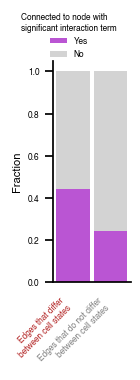

In [32]:
bars = ["Edges that differ\nbetween cell states", "Edges that do not differ\nbetween cell states"]
prop_table_edges_cluster = [
    [x/sum(cont_table_edges_cluster[0]) for x in cont_table_edges_cluster[0]],
    [x/sum(cont_table_edges_cluster[1]) for x in cont_table_edges_cluster[1]]
]
red_bars = [v[0] for v in prop_table_edges_cluster]
gray_bars = [v[1] for v in prop_table_edges_cluster]


barWidth = 0.9
fig, ax = plt.subplots()
fig.set_size_inches(1.5, 4);
plt.bar(bars, red_bars, color="mediumorchid", width=barWidth, label="Yes")
plt.bar(bars, gray_bars, bottom=red_bars, color="lightgray", width=barWidth, label="No")
plt.ylabel("Fraction", fontsize=8)
ax.get_xticklabels()[0].set_color("firebrick")
ax.get_xticklabels()[1].set_color("gray")
ax.spines['top'].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="x", bottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(-0.5,1.25), ncol=1, 
           frameon=False, prop={'size': 6}, 
           title = "Connected to node with\nsignificant interaction term",
          title_fontsize=6);
plt.tight_layout();

##### Per cluster node enrichment

In [33]:
# For each cluster (except the reference cluster)
ia_idev = [] # Node has interaction and incoming deviation edge
ia_nidev = [] # Node has interaction, no incoming deviation edge
nia_idev = [] # Interaction, no deviating edge incoming
nia_nidev = [] # No interaction, no deviating edge incoming

for cluster in set(df_ia_c1.cluster):
    # Get nodes with a significant interaction term in that cluster
    ia_nodes_cluster = set(df_ia_c1[df_ia_c1.cluster == cluster].node)
    nia_nodes_cluster = set(all_nodes) - ia_nodes_cluster
    
    # Get significant deviating edges in that cluster
    dev_pars = set(sol_dev_tidy[(sol_dev_tidy.pval < 0.05) & (sol_dev_tidy.Cluster == str(cluster))].Edge)
    dev_edges_cluster = set([tuple(par.split("_")[1:]) for par in dev_pars if par.startswith("r_")])
    nondev_edges_cluster = set(all_edges) - set(dev_edges_cluster)

    # Nodes with incoming edge deviating
    idev = set([edge[0] for edge in dev_edges_cluster])
    # Nodes without incoming edge deviating
    nidev = set(all_nodes) - idev
    
    # Update the contingency table elements
    ia_idev   += list(ia_nodes_cluster.intersection(idev))
    ia_nidev  += list(ia_nodes_cluster.intersection(nidev))
    
    nia_idev  += list(nia_nodes_cluster.intersection(idev))
    nia_nidev += list(nia_nodes_cluster.intersection(nidev))
    

        

cont_table_nodes_cluster = [
    [len(ia_idev),  len(ia_nidev)],
    [len(nia_idev), len(nia_nidev)]]


pd.DataFrame(cont_table_nodes_cluster, 
             index = ["Nodes with interaction", "Nodes without interaction"],
             columns = ["Incoming deviating edge", "No non-deviating edge"]
            )

,Incoming deviating edge,No non-deviating edge
Nodes with interaction,13,41
Nodes without interaction,26,256


In [34]:
scipy.stats.fisher_exact(cont_table_nodes_cluster, alternative = "greater")

(3.1219512195121952, 0.0035681285750326854)

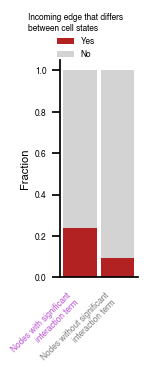

In [35]:
bars = ["Nodes with significant\ninteraction term", "Nodes without significant\ninteraction term"]
prop_table_edges = [
    [x/sum(cont_table_nodes_cluster[0]) for x in cont_table_nodes_cluster[0]],
    [x/sum(cont_table_nodes_cluster[1]) for x in cont_table_nodes_cluster[1]]
]
red_bars = [v[0] for v in prop_table_edges]
gray_bars = [v[1] for v in prop_table_edges]

matplotlib.rc('xtick', labelsize=6) 
matplotlib.rc('ytick', labelsize=6) 
matplotlib.rc('legend',**{'fontsize':6})

barWidth = 0.9
fig, ax = plt.subplots()
fig.set_size_inches(1.5, 4);
plt.bar(bars, red_bars, color="firebrick", width=barWidth, label="Yes")
plt.bar(bars, gray_bars, bottom=red_bars, color="lightgray", width=barWidth, label="No")
plt.ylabel("Fraction", fontsize=8)
ax.get_xticklabels()[0].set_color("mediumorchid")
ax.get_xticklabels()[1].set_color("gray")
ax.spines['top'].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="x", bottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(-0.5,1.25), ncol=1, 
           frameon=False, prop={'size': 6}, 
           title = "Incoming edge that differs\nbetween cell states",
          title_fontsize=6);
plt.tight_layout();

### Bootstrapping analysis

To assess how sensitive the selection of differing edges is to the input data, we performed 100 bootstraps and check in which fraction of bootstraps the initially selected edges occur.

In [36]:
with open('../results/bootstraps/cnr_full.pickle', 'rb') as f:
    sol_bootstraps = pickle.load(f)
len(sol_bootstraps)

100

In [37]:
df_bootstraps = pd.concat([s.deviations_overview for s in sol_bootstraps])
recur_diffs_bootstraps = df_bootstraps.index.value_counts()/len(sol_bootstraps)
recur_diffs_bootstraps = pd.DataFrame({"fraction": recur_diffs_bootstraps})
recur_diffs_bootstraps = recur_diffs_bootstraps.loc[sol_ref.deviations_overview.index]
recur_diffs_bootstraps['rank'] = recur_diffs_bootstraps.fraction.rank(method="first", ascending=False)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


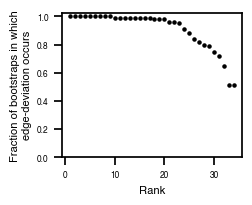

In [38]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(2.5, 2)
plt.scatter(recur_diffs_bootstraps['rank'], recur_diffs_bootstraps.fraction,
    color='black', s=5);
#plt.xticks(list(recur_diffs_bootstraps.index))
plt.xlabel("Rank");
plt.ylim(0);
plt.ylabel("Fraction of bootstraps in which\nedge-deviation occurs");
plt.tight_layout()
fig.savefig('../figures/scIDseq/CNR/bootstrap-fractions.pdf', dpi=100)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


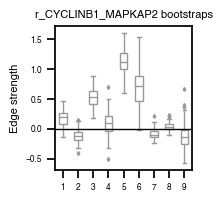

In [39]:
def plot_cnr_all(par):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(2, 2)
    sns.boxplot(
        x="variable", y="value",  data = pd.melt(df_bootstraps.loc[par]),
        order=["1", "2", "3", "4", "5", "6", "7", "8", "9"],
        linewidth=1, color='w', fliersize=2, width=0.5
    );
    plt.xlabel("")
    plt.ylabel("Edge strength")
    plt.axhline(0, c="black", linewidth=1)
    plt.title(par + " bootstraps", fontsize=8)
    plt.tight_layout()
    return fig
plot_cnr_all("r_CYCLINB1_MAPKAP2");
plt.savefig('../figures/scIDseq/CNR/bootstrap-r_CYCLINB1_MAPKAP2.pdf', dpi=100)

### Highlight subnetwork

In [43]:
c5_sig_edges = sol_dev_tidy[(sol_dev_tidy.pval < 0.05) & (sol_dev_tidy.Cluster == "5")]['Edge']
c5_sig_edges = [(n.split("_")[2], n.split("_")[1]) for n in list(c5_sig_edges)]

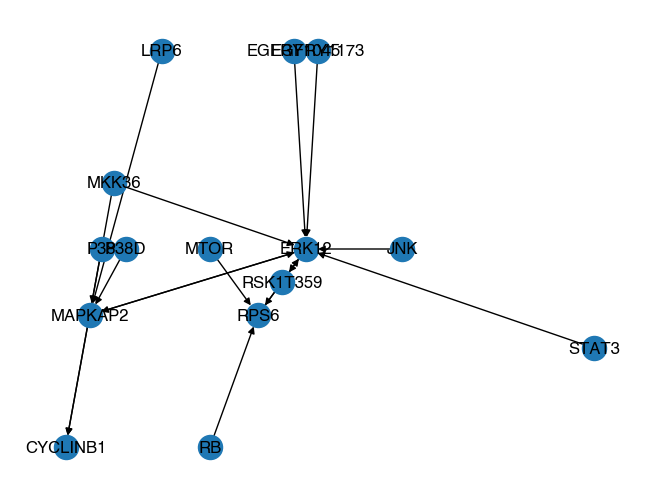

In [47]:
edge_lst = [] 
highlighted_nodes = ["ERK12", "MAPKAP2", "RSK1T359", "RPS6", "CYCLINB1"]
for node in highlighted_nodes:
    edge_lst += list(g.in_edges(node))
sg = g.edge_subgraph(edge_lst)

# Which nodes should be highlighted
nx.set_node_attributes(
    sg,
    {n: str(n in highlighted_nodes) for n in sg.nodes()},
    name="highlight"
    
)

nx.set_edge_attributes(
    sg,
    {e: str(e[0] in highlighted_nodes and e[1] in highlighted_nodes) for e in sg.edges()},
    name="highlight"
    
)


nx.set_edge_attributes(sg, {e: str((e in c5_sig_edges)) for e in list(sg.edges())}, name = "color")


nx.set_edge_attributes(
    sg, {e: sol_ref.vardict["_".join(["r", "5", e[1], e[0]])] for e in sg.edges()}, 
    name = "strength")

nx.draw(sg, pos=node_positions, with_labels=True)
nx.write_gml(sg, "../results/graph_highlight.gml")